<a href="https://www.kaggle.com/code/gebrielgidey/transformer-sentiment-analyzer?scriptVersionId=178870744" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center" style="color:Gold;font-size: 3em;" >Sentiment Analysis of Amazon Reviews using Transformers</h1>

## This program is broken down into 3 sections:

**1. We will work on data cleaning and preprocessing.**

**2. We will then work on creating the sentiment analyzer and train it on the data we have preprocessed.**

**3. Finally, we will evauate our model and visualize the results.**

***Heads Up: Some of the cells might not have an output after they finish running. This is completely normal. You can always hover over the play button you click to run them and it will let you know if the cell has been executed and how long the process took. If there ever is an error, the cell will print out the stack trace and the issue it encountered.***

## Let us begin by importing the necessary libraries

***Heads Up: You might see a warning when importing the packages, but you may ignore this, as it won't cause any issues for our needs.***

In [1]:
#>> updated 4/1
# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries
import re
import math
import nltk
import spacy
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
import matplotlib.pyplot as plt

# Getting particular functions from these libraries
from scipy import stats
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin') or ('.gz'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}') #<< faster than doing api.load
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = True
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = True
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('VERBOSE:', text)
    return

showCellCompletion = False
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = True
accelerator = True

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Amazon reviews file: /kaggle/input/amazon-product-reviews/Reviews.csv
Google news word to vec file: /kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


**This magic command we are running below gives the notebook access to parts of the NLTK library. When ran correctly, it should unzip the wordnet file and copy over its contents.**

**Please only run this command once when you start the notebook. If you run it again, it will prompt you to replace the existing files. After you run it once, you may comment it out. If you happen to run it again, and you see are prompted for a response, simply stop the cell and move on to the next section.** 

<span style="color:green">"prompt as a response" should be "prompted for a response"?</span>

In [2]:
## Only run once
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Section 1: Data Cleaning and Preprocessing

**One thing that you will here when often working with data is that preprocessing it is the most important part. If the data is not cleaned and prepared for the model, you will always get sub-par results.**

**The image below serves to illustrate what we aim to achieve in this section. It may look confusing now, but things will be clearer as we go through the section.**

**For this project, we will be using over 568,000 reviews collected from Amazon. The cell below the image contains the code that will give us access to the dataset. You can also find the dataset linked here.**

<span style="color:green">Note that a word embedding is a representation of a word in an n-dimensonal vector space, n ≥ 2</span>

[Amazon Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

![Example of Embeddings](https://www.researchgate.net/publication/340825443/figure/fig6/AS:882927785238529@1587517796128/Word-embeddings-map-words-in-a-corpus-of-text-to-vector-space-Linear-combinations-of.png)

* Source: [Word embeddings map words in a corpus of text to vector space](https://figshare.com/articles/figure/Word_embeddings_map_words_in_a_corpus_of_text_to_vector_space_/12169047/1)

**Let's access the dataset and see how many reviews we actually have.**

In [3]:
# Load data from CSV
#>>  3/13 needed to change the path as below
# path ='/kaggle/input/Reviews.csv'#"/kaggle/input/amazon-product-reviews/Reviews.csv"
data = pd.read_csv(reviews_file) # Use pandas to analyze data
showD('Amazon reviews loaded into Panda')

# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Amazon reviews loaded into Panda
VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3 

**Check for empty entries or missing data in each column**

In [4]:
for column in data.columns:
    if data[column].isnull().values.any():
        print(f"Column '{column}' has empty entries or missing data.")
    else:
        print(f"Column '{column}' has no empty entries or missing data.")

Column 'Id' has no empty entries or missing data.
Column 'ProductId' has no empty entries or missing data.
Column 'UserId' has no empty entries or missing data.
Column 'ProfileName' has empty entries or missing data.
Column 'HelpfulnessNumerator' has no empty entries or missing data.
Column 'HelpfulnessDenominator' has no empty entries or missing data.
Column 'Score' has no empty entries or missing data.
Column 'Time' has no empty entries or missing data.
Column 'Summary' has empty entries or missing data.
Column 'Text' has no empty entries or missing data.


**Here we can use a pandas data object methods to sample the data and display the elements of it.**

In [5]:
# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                     

**The data has 1O columns, including "Score," indicating the review's sentiment, and "Text," the product review the score is based on. In Machine Learing, Text would be called the FEATURE, the term for the column(s) used for inference.**


**There is far too much data to print, but we can print the total number of reviews per rating and use the functions provided to us by matplotlib to visualize the distribution as a bar graph.**

52,268 samples from balanced data with rating 1

29,769 samples from balanced data with rating 2

42,640 samples from balanced data with rating 3

80,655 samples from balanced data with rating 4

363,122 samples from balanced data with rating 5



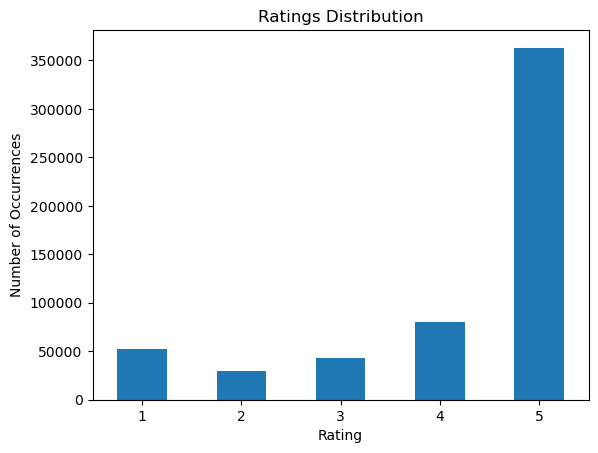

In [6]:
# Get count of ratings 
rating_counts = data['Score'].value_counts()

# Sort counts by index ascending
rating_counts = rating_counts.sort_index()  

# Create bar plot
ax = rating_counts.plot(kind = 'bar')

ax.set_title("Ratings Distribution")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Occurrences")

# Fix x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0) 

for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show() #<< show the rating in each of the 5 categories

**The distribution looks heavily skewered to the positive side, with 5 star reviews making up more than half of our dataset. While that's great for Amazon and its customers, it could bias our model and starve it of adequate negative and neutral reviews to train on.**

**To work around this, we can try to balance out our data. Given how we have the least number 2 rating reviews, let's take 25,000 reviews from each rating to give our model an even dataset, giving us a total of 125,000 reviews to work with. But fret not, because that is still a vast amount of data to work with.**

**To do this, we can sort the data in ascending order and take 25,000 reviews from each rating class.**

In [7]:
balanced_data_size = 10000#28000 #<< number of reviews in each rating category, tailored for CPU capacity

# Specify the column for sorting and balancing
sort_column = 'Score'  # This is one the rating column

# Sort the data by the rating values
sorted_data = data.sort_values(by = sort_column)

# Get 'balanced_data_size' revievws from each rating class
balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))

#>> Does this mean to reset the row numbers?? ##Columns Numbers
balanced_data.reset_index(drop = True, inplace = True)

printv(f"The number of reviews equally distributed across all ratings is {len(balanced_data['Score'])}")

VERBOSE: The number of reviews equally distributed across all ratings is 50000


**We can use matplotlib to see that reviews are equally distributed across all rating categories in the balanced data.**

10,000 samples from balanced data with rating 1

10,000 samples from balanced data with rating 2

10,000 samples from balanced data with rating 3

10,000 samples from balanced data with rating 4

10,000 samples from balanced data with rating 5



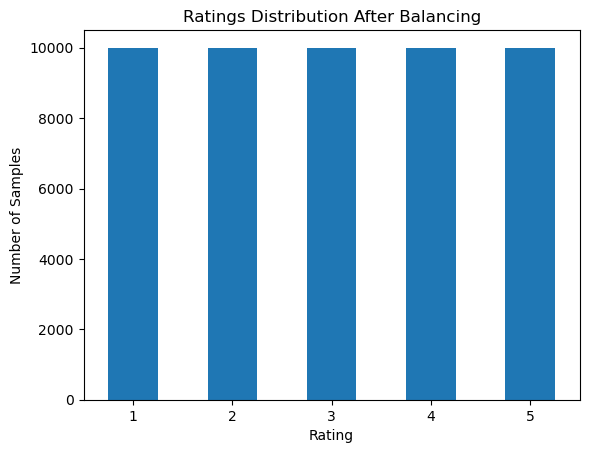

In [8]:
# Get count of ratings
rating_counts = balanced_data['Score'].value_counts()

# Create bar plot
ax = rating_counts.plot(kind='bar')

ax.set_title("Ratings Distribution After Balancing")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Samples")

# Fix x-axis ticks  
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

# Print number of reviews per rating

if DEV:
    for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show()

**That looks much better. We see that each rating class is sufficiently represented, and we can expect to get a more well-rounded analyzer. While this is a good way to even things out, our model can still be biased due to the reviews themselves. People leave comments when they have stronger opinions about a product. This is why balancing the types of reviews we give our model is necessary, so that the model can get a complete representation of the range of opinions**

**We will also encounter things like typos, improper punctuation and spacing, along with other grammatical issues. While we will leave the dataset as is for now, it is important to try other approaches to identify these issues and filter them out.**

**Now that we have our dataset ready, let's get to work on preprocessing it. Our reviews contain things like punctuations that we don't need to work with. To get rid of these, we use regular expressions to filter them out, and convert every character to lowercase to achieve uniformity.**

**Something else we can do is a process called Lemmatization. This is the process of replacing variants of a word by the base word itself. An example of this would be to change the words knew, knowing, and known to their base word: know. This will help us achieve better uniformity by avoiding the misplacement of a word's variants.** <span style="color:blue">Do you actually use the lemmatizer?

In [9]:
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=47894 sha256=4e8ab25b9cc0950db1e942d41385e6c0d3476270941a860128cb6785d9c2beaa
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [10]:
custom_stop_words =['d', "'s" , "it's", 'll', 'm', 'ma', 'most', 'mustn', 
"mustn't", 'needn', "needn't", 'o','re', 's', "she's", 'so', 'some', 'such',
't', "that'll", 've', 'wasn', "wasn't", 'y', 'you', "you'd", "you'll", "you're"
, "you've", 'yourselves', ' ']

In [11]:
import pkg_resources
from symspellpy import SymSpell

stop = stopwords.words('english') # Imported from nltk.corpus
lem = WordNetLemmatizer()         # Imported from nltk.stem

# Load the English tokenizer model from spaCy
nlp = spacy.load("en_core_web_lg")

# Compile the regular expressions for cleaning text
html_tags = re.compile("<.*?>")
punct_and_symbols = re.compile(r'[^\w\s\']+')

# Initialize and load SymSpell dictionary for word segmentation
sym_spell = SymSpell(max_dictionary_edit_distance = 0, prefix_length = 7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index = 0, count_index = 1)

True

In [12]:
printd (f'{stop}\n')
printd (f'{lem}\n')

# test lemmatizer
word = "dogs"
lemmatized_word = lem.lemmatize(word)
print(lemmatized_word)

DEV: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'tha

**Let's create a function that takes our reviews and returns a lemmanized, lower-case, punctuation-free version of it.** **We can then store this new version in a new column called 'CleanedReview' for easy access.**

***Heads up: This cell takes a little longer to execute.***

In [13]:
def tokenizer(text, nlp, sym_spell, custom_stop_words):
    """
    Tokenizes a text string, segments run-on words, and removes stop words.
    
    text (str): The text string to tokenize.
    nlp: The spaCy language model.
    sym_spell: The SymSpell object for correcting run-on words.
    custom_stop_words (list): A list of custom stop words to remove.

    Returns:
        list: The tokenized text string.
    """
    # Clean text
    text = text.lower()  # Convert text to lowercase
    text = html_tags.sub("", text)  # Remove HTML tags
    # text = punct_and_symbols.sub("", text)  # Replace punctuation and symbols with space
    text = punct_and_symbols.sub(" ", text)  # Replace punctuation and symbols with space

    # Segment text using SymSpell
    segmented = sym_spell.word_segmentation(text)
    clean_text = segmented.corrected_string
    
    # Tokenize the text using spaCy
    doc = nlp(clean_text)

    # Remove stop words and punctuation tokens
    tokens = [token.text for token in doc if not token.is_punct 
              and token.text not in custom_stop_words] 

    return tokens

# Assuming 'balanced_data' is a pandas DataFrame with a column 'Text'
# Apply the tokenizer function to the 'Text' column
balanced_data['CleanedReview'] = balanced_data['Text'].apply(lambda x: tokenizer(x, nlp, sym_spell, custom_stop_words))

# Indicate completion
print('Tokenizer defined, and CleanedReview column created')

Tokenizer defined, and CleanedReview column created


**Another look at the data after the addition of the CleanedReview column.**

In [14]:
# Store the Rating column
rating = balanced_data['Score']  

# Store the CleanedReview column
tokenized_review = balanced_data['CleanedReview']
showD(f'specify the columns that will be used to train the classifier')

for i in range (5):
    print(balanced_data['Text'][i],'\n')
    print(tokenized_review[i], '\n')
    print(len(tokenized_review[i]), '\n')
    print(tokenized_review.shape)

VERBOSE: specify the columns that will be used to train the classifier
BIG DISAPPOINTMENT !!!!! I'm so glad that Amazon makes GOOD on BAD product. I had to return after I got sick from drinking it.<br /><br />There was no mfg. date on can as indicated, this could have been the problem too.<br /><br />Maybe I got a bad batch, but this is horrible!!! 

['big', 'disappointment', '  ', 'i', "'m", 'glad', 'that', 'amazon', 'makes', 'good', 'on', 'bad', 'product', 'i', 'had', 'to', 'return', 'after', 'i', 'got', 'sick', 'from', 'drinking', 'it', 'there', 'was', 'no', 'mfg', 'date', 'on', 'can', 'as', 'indicated', 'this', 'could', 'have', 'been', 'the', 'problem', 'too', 'maybe', 'i', 'got', 'a', 'bad', 'batch', 'but', 'this', 'is', 'horrible'] 

50 

(50000,)
Tried this on my bird feeder and watched the results. Sprayed heavily on the approach to the feed, up the pole on which the feeder was suspended, on the feeder itself, on the sunflower seeds and on the suet blocks. The squirrels appeare

**We can see that our data now has 11 columns, with the addition of CleanReview, and that the CleanedReview column is the product review mapped to a sequence of standardized words.**

**Let's analyze what our new data looks like further**

Mean: 91.20
Median: 66.00
Mode: ModeResult(mode=array([27]), count=array([680]))


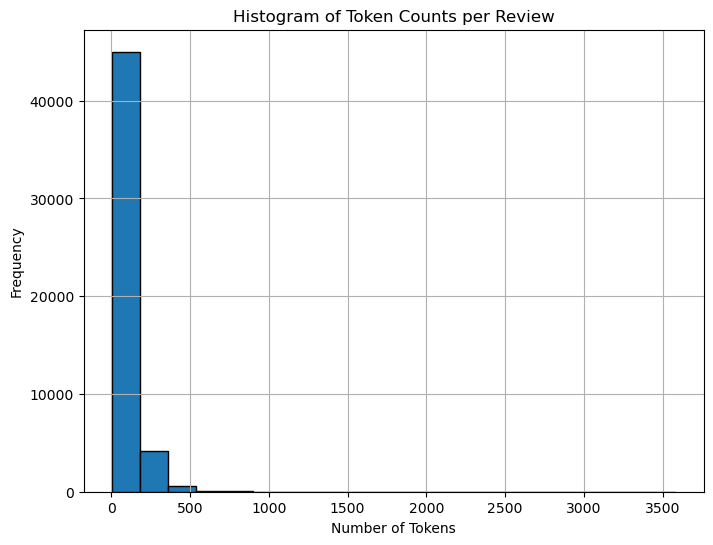

In [15]:
def analyze_review_tokens(reviews):
    token_counts = [len(review) for review in reviews]

    mean = np.mean(token_counts)
    median = np.median(token_counts)
    mode = stats.mode(token_counts)

    print(f"Mean: {mean:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Mode: {mode}")

    plt.figure(figsize=(8, 6))
    plt.hist(token_counts, bins=20, edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Histogram of Token Counts per Review')
    plt.grid(True)
    plt.show()

analyze_review_tokens(tokenized_review)

**There are just a few more steps remaining before we can load the data. We have to tokenize the words from the reviews because neural networks, much like computers, don't really understand words. Instead, our tokenizer is going to associate every word with a number that can be used to look up the word's embeddings.**

**Think of embeddings as vector representations of the word in space.**

**There are many approaches we can take to vectorizing our reviews, so much so in fact that word embeddings are a big part of Natural Language Processing. Without getting too bogged down in details, some approaches use statistical approaches like bag-of-words to figure out context, and others can use neural network-based models that are trained to find features themselves.** 

**The quickest way would be to take an already trained tokenizer made for established transformer-based models. For example, the BertTokenizer is a tokenizer that was trained and used by BERT. BERT is a massive Transformer-based model created by Google in 2018. It was a significant achievement because it was able to perform up to 11 NLP tasks, including summarization, text-generation(think ChatGPT), and even sentiment analysis.**

**Word2vec-google-news-300 is a pre-trained deep-learning word embedding model that was trained on a massive dataset of 100 billion words from the Google News corpus. The model contains 300-dimensional vectors for 3 million words and phrases. That is what we will be using for this project**

**Word2Vec extracts both semantic and contextual representations of words. The semantic representation of a word captures the meaning of the word itself, while the contextual representation captures the meaning of the word in the context of the surrounding words.**

**To explain what's happening in the Word2Vec embedding process:**

1. **The tokenizer splits the raw text into tokens/words.**
2. **Word2Vec has IDs that serve as indices into a lookup table that stores the vector representations, meaning that each ID corresponds to a unique vector representation in the table.**
3. **For each token, we lookup the corresponding ID in the Word2Vec vocabulary using .key_to_index.**
4. **This maps the tokens to existing Word2Vec IDs.**
5. **We pass these IDs into the embedding layer.**
6. **The embedding layer has a 300-dim vector for each ID.**
7. **So each token gets replaced by its pre-trained 300-dim Word2Vec vector.**

**To summarize:**

* **Tokenizer splits text into words.**
* **Word2Vec vocab provides ID for each word.**
* **Embedding layer maps IDs to 300-dim vectors.**
* **So tokens are replaced by 300-dim pretrained embeddings.**

**Let's call our word2vec model and set a variable we will use to limit the number of out tokens per review to 100 tokens. We will later zero-pad these reviews so we can have a uniform number of tokens per review.**

In [16]:
# Load Word2Vec model
w2v = KeyedVectors.load_word2vec_format (w2v_file, binary=True)

showD(f'{w2v} can map words onto vectors with 300 dimensions')

VERBOSE: KeyedVectors<vector_size=300, 3000000 keys> can map words onto vectors with 300 dimensions


**Now that we have downloaded our model, let's use our CUDA-enabled GPU to take our token and look for its corresponding vector from our model. Once we find it, we swap it out with the new vector and if we don't, we pad that token with zeros.**

In [17]:
# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

CUDA is available!
GPU 0: Tesla P100-PCIE-16GB


**After ensuring that we have our GPUs available, we can go onto the next step. The code continues even if a CUDA is not available.**

**In the cell below, we will do the following:**

* **Create a new tensor and populate it with zeros**
* **Compare the length of our review to the maximum length we allow (100) and take the minimum of the two**
* **We lookup the token against what's in the w2v model. If we find it, we replace it with the embedding.**
* **If we can't find it, we leave it as is (zero vectors).**

***Heads Up: Cell below takes about 5 minutes to run***

In [18]:
lengths = []
for review_tokens in tokenized_review:
    lengths.append(len(review_tokens))

lengths = sorted(lengths)
lengths = lengths[-1:0:-1]
showD(f'Lengths of 100 longest reviews: {lengths[0:100]}')

max_sequence_length = 100

# Initialize an empty tensor for padded reviews on the GPU
padded_reviews = torch.zeros((len(tokenized_review), max_sequence_length, 300))

out_words = {}
words_in = 0
words_out = 0

# Padding and embedding conversion loop, no mask updates
for i, review_tokens in enumerate(tokenized_review):
    review_length = min(len(review_tokens), max_sequence_length)
    for j in range(review_length):
        word = review_tokens[j]
        if word in w2v:
            words_in += 1
            # Use Word2Vec vector if available
            padded_reviews[i, j, :] = torch.tensor(w2v[word])
        else:
            words_out += 1
            out_words[word] = out_words.get(word, 0) + 1

printv(f'{words_in} words found with vector representations, {words_out} without')
printv(f'Number of unique words without vector representations: {len(out_words)}')
printd('Sample of words without vector representations')
kwords = list(out_words.keys())
for idx in range(0,len(kwords)-1,100):
    kword = kwords[idx]
    printd(f'{kword} - {out_words[kword]}')

# Apply max pooling to aggregate embeddings along the sequence dimension
# review_embeddings = torch.max(padded_reviews, dim=1)[0]

showC(f"Created zero-padded, standard length reviews")

print(padded_reviews[1])

VERBOSE: Lengths of 100 longest reviews: [3581, 2249, 1877, 1628, 1555, 1555, 1555, 1481, 1377, 1375, 1361, 1253, 1253, 1225, 1211, 1208, 1208, 1161, 1123, 1097, 1072, 1072, 1072, 1058, 1032, 1020, 962, 961, 925, 922, 922, 912, 897, 896, 891, 872, 867, 864, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 856, 854, 854, 850, 850, 850, 842, 839, 833, 805, 800, 799, 798, 794, 793, 792, 785, 782, 781, 781, 777, 776, 776, 776, 775, 750, 746, 746, 744, 740]
VERBOSE: 2899568 words found with vector representations, 401733 without
VERBOSE: Number of unique words without vector representations: 3008
DEV: Sample of words without vector representations
DEV:    - 78133
DEV: 55 - 52
DEV: qwik - 1
DEV: 1987 - 3
DEV: lynnette - 1
DEV: ehhhh - 2
DEV: ebie - 1
DEV: dcided - 1
DEV: afficia - 1
DEV: lowery - 4
DEV: 4x1 - 1
DEV: kapi - 1
DEV: zylitol - 3
DEV: metz - 2
DEV: ooooooo - 6
DEV: 86 - 

**Now, "review_embeddings" contains the aggregated Word2Vec embeddings for each review on the GPU.**

**Once we have our embeddings ready, we can prepare them as inputs for the model. The next step is to convert our inputs, now converted to embedding-rich vectors, to tensors. Tensors are a kind of data structure that store information in multidimensional space. They are a generalization of vectors and matrices, and can have any number of dimensions.**

**Converting vectors to tensors is computationally expensive, which is one of the reasons why GPUs are the main processors used in AI. GPUs are specialized for performing parallel computations, which makes them ideal for tasks such as tensor conversion.**

**But first, a quick introduction to PyTorch. PyTorch is a popular deep learning framework that provides a lot of resources for building deep learning architectures, including popular pretrained models. It has become prevalent in academia, research, and industry, being utilized by Tesla, Uber, Hugging Face, and many more.**

**PyTorch will help us convert our vectors to tensors. It also support GPU acceleration. CUDA is a firmware developed by NVIDIA that allows GPUs to be used for general-purpose computing, such as tensor conversion.**

**Once the embeddings have been converted to tensors, we can print out the dimensions of our new dataset. This will tell us how many data points we have and how many features each data point has. We can then load the dataset to our data loaders, which will prepare it for training the neural network.**

![Tensors](https://hkilter.com/images/7/7a/Tensors.png)

* Source: [What is Tensor](https://hkilter.com/index.php?title=What_is_Tensor%3F)

**When we utilize tokenization and convert them to their embeddings, we are only doing this for one instance of them to avoid redundancy. So for example, if the word "the" appears 2000 times, it would only count once for unique tokens.**

*Thus, a total of 39,753 unique tokens were converted to vectors and 9,373,966 was the total number of tokens including duplicates were converted into tensors and stored in our GPU.*

**Since this Word2Vec model is trained on a huge corpus, it likely has vectors for the vast majority of tokens we extracted. The only ones missing would be very rare or irregular words.**

***Note: It is imporant to remember that we are not just using this vocabulary as a look-up dictionary. That's just a small part of the step. What we are doing is far more advanced. The embeddings are rich contextual vectors that will highlight the relationships between words in different ways. For example, lexicographically speaking, the word 'car' is more similar to 'cat', but when viewed semantically, and/or in terms of its context, it is far more similar to 'dog'. Same goes for the word 'bank', which can be used to refer to a financial institution or the side of a river. These kinds of relationships are the foundation for our model and will serve as the basis for how it perceives them.***

In [19]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
rating_labels_tensors = torch.tensor(rating.values).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

print(text_embeddings_tensors.shape)
print(rating_labels_tensors.shape)
print(text_embeddings_tensors.device)
print(rating_labels_tensors.device)
print(dataset)

# DataLoader for training data
data_loader = DataLoader(dataset, batch_size = 32, shuffle = False)

printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
print('\n\n\n\n\n\n\n\n\n\n')

if accelerator and showNv:
    print(torch.cuda.memory_summary())

torch.Size([50000, 100, 300])
torch.Size([50000])
cuda:0
cuda:0
Total allocated memory: 6000400384 bytes
Tue May 21 06:37:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              33W / 250W |   6120MiB / 16384MiB |     37%      Default |
|                                         |          

**Our output confirms that we have successfully converted our data to tensors and is now loaded on our GPU. The output shows that CUDA is available and the GPU name is Tesla P100-PCIE-16GB. The text_tensor and rating_tensor are both on the GPU (device='cuda:0'). The shape of the text_tensor is torch.Size([125000, 100, 300]), which means that it has 125000 rows, 100 columns, with 300 embeddings per column. The shape of the rating_tensor is torch.Size([125000]), which means that it has 125000 rows (ratings). The mean of the rating_tensor is 3 meaning that the we have perfectly divided all our ratings.**

![numeric_tensors](https://miro.medium.com/v2/resize:fit:1400/1*Shsgt3h9yxlQwjkfIptfYQ.png)

* Source: [From Vectors to Tensors: Exploring the Mathematics of Tensor Algebra](https://towardsdatascience.com/what-are-tensors-in-machine-learning-5671814646ff)

**We can now split our dataset into training and validation sets. When working on machine learning or deep learning models, we want to train the model on a subset of the data, and then test the accuracy of the model's predictions on the remaining data. This is called data splitting. We typically split the data into an 80/20 split, where we train the model on 80% of the data and test it on the remaining 20%.**

**And there we have it! It looks like we have successfully split our data 80/20, and are now going to load the tensors in batches to our training and validation loaders. We will use these to load our data into the model once we have finished building it. We have also stored the data in batches of 32. This will make it easier to process the data instead of dealing with the whole thing at once. To confirm that it is all loaded, we can see that the number of batches, 3,125, multiplied by the batch size, 32, will indeed return 125,000**

**We have successfully completed the preprocessing, splitting, and loading of our data. This section may have felt overwhelming, but it is important to remember that preparing the data properly is just as important as building the model. In fact, it is often said that 80% of the work in machine learning is in data preparation. This is because the quality of the data will have a significant impact on the performance of the model.**

**And now for the really exciting part: the Transformer, the T in Chat-GPT. Arguably one of the most impactful architectures in recent history, the Transformer has been the state of the art in natural language processing (NLP) and other sequence-to-sequence tasks. In this section, we will break down and build on the individual components of this architecture, and use it to create our sentiment analyzer.**

# Section 2: The Sentiment Analyzer

![Detailed Architecture Diagram](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/model-min.png)

* Source: [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

**Above is a diagram of what the Transformer architecture looks like. It might look complicated, but each cell will work on one component of the layer so we can isolate and understand the various sections of our model.**

***Heads Up: Since we are building a sentiment analyzer, we will not be generating any outputs. Instead we will just use a simple classifier to make our classifications. Thus, we will not be using the decoder layer (the longer section on the right side of the diagram). But do note that, while most of the components are indeed similar, the two layers function somewhat differently.***

## Here is a quick rundown of what our Transformer model will contain the following:

## 1. Embedding Layer:

### a. Word Embeddings: 
**These are the learned dense vectors that represent each word in 
your vocabulary. These vectors capture the semantic meaning of words. Of course, for our use case, we are utilizing the embeddings from word2vec**

### b. Positional Encodings: 
**These are vectors that encode the position of each word in the 
sequence. They help the attention mechanism also take the positoning of the words when factoring in the attention scores.**

## 2. Encoder Layer:

### a. Multi-Head Attention: 
**This mechanism allows the model to attend to different parts of the
input sequence while capturing various relationships between words.**

### b. Addition (Residual) and Normalization Layer: 
**After multi-head attention, you typically have a residual connection 
(addition) followed by layer normalization. This helps with stable 
training and information flow.**

### c. Feed-Forward Neural Network (Pointwise Feed-Forward Layer): 
**This network applies a simple feed-forward transformation to each 
position separately, allowing the model to capture non-linear 
relationships between words.**

## 3. Classifier Layer:

### a. Linear Layer: 
**This layer maps the output of the encoder to the number of classes 
you have in your sentiment analysis task. For example, if you have 
three sentiment classes (negative, neutral, positive), this layer
will output logits for each class.**

### b. Softmax Activation: 
**This activation function is applied to the logits to convert them 
into probabilities for each class. It makes the model's output 
interpretable as class probabilities.**

**When following the diagram as a pipeline, we see that the first thing we do with the inputs is include the embedding. The embedding is layer involves replacing the tokens from our reviews with their vectors. SInce we have used Word2Vec to create the embeddings from our tokens, we just need may proceed to the next step.** **The next step in our diagram is the Positional Encoding. This is a clever approach that the creaters of the Transformer architecture utilized to include even more information into our input embeddings. While the first set of vectors helped give our tokens their contextual vectors, the positional encoder assigns a sin or cosine value to these vectors depending on whether they are located in odd of even positions. This adds to our vectors by highlighting the location of the token on top of its meaning, thus further enriching the information it carries.**

**We will wrap all this up in one function and call that Embeddings.**

**Now we delve into what truly makes the Transformer architecture exceptional: the Attention mechanism. This mechanism, often referred to as self-attention, has been a transformative development in NLP. It serves as a way to allocate "focus" or "attention" values to the different embedded vectors that pass through the model's embedding layer. This allocation is achieved by segmenting the input vectors into three key components: queries, keys, and values.**

**The process begins with the transformation of the input embeddings into three distinct matrices: the Query matrix (Q), Key matrix (K), and Value matrix (V). These matrices are obtained through linear transformations of the original embeddings.**

**The heart of the attention mechanism involves calculating dot products between the Query matrix and the Transposed Key matrix. The resulting dot products are then scaled by the square root of the dimension of the key vectors. This scaling factor plays a crucial role in maintaining stable gradients during training.**

**The next step in the process employs a softmax operation on the scaled dot products. The softmax function normalizes the values, converting them into attention weights. These attention weights indicate the "importance" or "weight" assigned to each word in relation to the others. The summation of the attention weights for each query-key pair ensures that the model focuses on the most relevant information.**

**The weighted sum of the Value matrix, determined by the attention weights, generates an attended representation. In essence, the attention mechanism enables the model to capture the contextual relationships between words, determining how much each word contributes to the overall understanding of the sequence.**

**One innovation that distinguishes the Transformer architecture is multi-head attention. Instead of relying on a single attention mechanism, multiple parallel attention mechanisms, or "heads," are employed. Each head attends to the input independently and learns different aspects of the relationships between words. The outputs of the different heads are concatenated and linearly transformed, resulting in a comprehensive representation that encompasses various perspectives on the input data.**

**Example:**

**Consider the sentence: "Diana wanted to visit Seattle in the Winter, but was ill-prepared for the cold, Pacific Northwest weather."**

**In this sentence, the attention mechanism discerns connections between words, prioritizing specific words when analyzing others. For instance, in the context of "visit Seattle," the word "Seattle" would attract more attention when considering the word "visit." Similarly, the words "ill-prepared" and "cold" would stand out in the presence of the term "Winter."**

# Hyperparameters

In [20]:
# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of our word embeddings
seq_len = 100  # Maximum sequence length
input_size = d_model  # based on the output size of our feed-forward network

num_layers = 10 # Number of encoder layers
num_heads  = 50 # number of attention head
d_ffn   = 2048 # dimension of the feedforward layer

dropout = 0.0 # we can adjust the dropout if needed
eps = 1e-6 # epsilon value to prevent the standard deviation from becoming zero

"""
To ensure compatibility, it's important to choose the
number of attention heads (h) such that d_model is
evenly divisible by h in the multi-head attention
module's self.d_k. This allows for a clean distribution
of the model dimensionality across the attention heads.
"""

# d_model / attn.h = 300 / 30 = 10

"\nTo ensure compatibility, it's important to choose the\nnumber of attention heads (h) such that d_model is\nevenly divisible by h in the multi-head attention\nmodule's self.d_k. This allows for a clean distribution\nof the model dimensionality across the attention heads.\n"

# Positional Encoding

In [21]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, dropout: float, seq_len: int):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

The provided code defines a PyTorch module called `PositionalEncoding`, which implements positional encoding for transformer models. Positional encoding is a technique used to inject information about the relative or absolute position of tokens in a sequence into the input embeddings.

Here's a breakdown of what the code does:

1. The `PositionalEncoding` class is defined as a subclass of `nn.Module`, indicating that it is a PyTorch module.

2. The `__init__` method is the constructor of the class and takes three parameters:
   - `d_model`: The dimensionality of the model (embedding size).
   - `dropout`: The dropout probability for regularization.
   - `seq_len`: The maximum sequence length.

3. Inside the constructor:
   - A dropout layer is created using `nn.Dropout` with the specified dropout probability.
   - A tensor `position` is created using `torch.arange(seq_len).unsqueeze(1)`, representing the positions from 0 to `seq_len-1`.
   - A tensor `div_term` is computed using `torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))`, which is used to create a geometric progression of frequencies.
   - A tensor `pe` (positional encoding) is initialized with zeros of shape `(seq_len, 1, d_model)`.
   - The odd indices of `pe` are filled with the sine of the position multiplied by the corresponding `div_term` value.
   - The even indices of `pe` are filled with the cosine of the position multiplied by the corresponding `div_term` value.
   - The `pe` tensor is registered as a buffer of the module using `self.register_buffer('pe', pe)`, so that it is saved and loaded with the module's state dict.

4. The `forward` method is defined to compute the output of the positional encoding module:
   - It takes an input tensor `x` of shape `[seq_len, batch_size, embedding_dim]`.
   - The positional encoding tensor `pe` is added to the input tensor `x` element-wise, broadcasting the positional encoding to match the shape of `x`.
   - The resulting tensor is passed through the dropout layer and returned as the output.

In summary, the `PositionalEncoding` module adds positional information to the input embeddings of a transformer model. It creates a fixed positional encoding tensor based on sine and cosine functions of different frequencies, which is added to the input embeddings. This allows the model to incorporate positional information and learn the relative positions of tokens in the sequence.

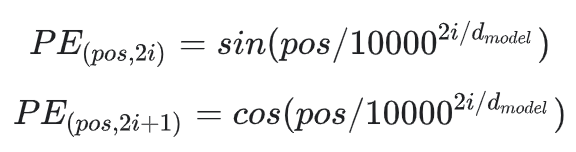

* Source: [Transformer Tutorial - Tensorflow](https://www.tensorflow.org/text/tutorials/transformer)

# Attention + Multi-head

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=dropout):
        super().__init__()

        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.dropout = nn.Dropout(p=dropout)

    @staticmethod
    def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        p_attn = torch.softmax(scores, dim=-1)
        
        if dropout is not None:
            p_attn = dropout(p_attn)
        
        return torch.matmul(p_attn, value), p_attn

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        x, attn = self.scaled_dot_product_attention(query, key, value, mask=mask, dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        return self.linears[-1](x)

Multi-head attention allows the model to attend to different parts of the input sequence simultaneously, capturing multiple relationships and dependencies.

Let's break down the code:

1. The `MultiHeadedAttention` class is defined as a subclass of `nn.Module`, indicating that it is a PyTorch module.

2. The `__init__` method is the constructor of the class and takes three parameters:
   - `h`: The number of attention heads.
   - `d_model`: The dimensionality of the model (embedding size).
   - `dropout`: The dropout probability for regularization.

3. Inside the constructor:
   - The dimension of each attention head `d_k` is calculated as `d_model // h`.
   - Four linear layers are created using `nn.Linear(d_model, d_model)` and stored in `self.linears` as a `nn.ModuleList`. These linear layers are used for transforming the query, key, value, and output.
   - A dropout layer is created using `nn.Dropout` with the specified dropout probability.

4. The `scaled_dot_product_attention` method is defined as a static method to compute the scaled dot-product attention:
   - It takes the query, key, value, and optional mask and dropout as input.
   - The dot product of the query and key is computed using `torch.matmul(query, key.transpose(-2, -1))`, and then scaled by dividing by the square root of `d_k`.
   - If a mask is provided, the scores are masked by setting the masked positions to negative infinity using `scores.masked_fill(mask == 0, float('-inf'))`.
   - The attention weights are computed by applying a softmax function to the scores using `torch.softmax(scores, dim=-1)`.
   - If dropout is provided, it is applied to the attention weights.
   - The attended values are computed by multiplying the attention weights with the value using `torch.matmul(p_attn, value)`.
   - The method returns the attended values and the attention weights.

5. The `forward` method is defined to compute the output of the multi-head attention module:
   - It takes the query, key, value, and optional mask as input.
   - The input tensors are transformed using the linear layers stored in `self.linears`, reshaped to have dimensions `(nbatches, -1, h, d_k)`, and transposed to have dimensions `(nbatches, h, -1, d_k)`.
   - The `scaled_dot_product_attention` method is called with the transformed query, key, value, mask, and dropout to compute the attended values and attention weights.
   - The attended values are reshaped back to have dimensions `(nbatches, -1, h * d_k)` by transposing and contiguous view.
   - The output is obtained by passing the reshaped attended values through the last linear layer in `self.linears`.

In summary, the `MultiHeadedAttention` module implements the multi-head attention mechanism, which allows the model to attend to different parts of the input sequence simultaneously. It splits the input into multiple attention heads, performs scaled dot-product attention on each head, and then concatenates and transforms the attended values to produce the final output.

![Self-Attention Diagram](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_explained-min.png)

![Components of Self-Attention](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_attention_formula-min.png)

* Source: [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

# Normalization Layer

In [23]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    
    def __init__(self, features, eps = eps):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

# Position-wise Feed Forward Network

In [24]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ffn: int, dropout: float):
        """
        Args:
            d_model:      dimension of embeddings
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ffn)
        self.w_2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x:            output from attention (batch_size, seq_length, d_model)

        Returns:
            expanded-and-contracted representation (batch_size, seq_length, d_model)
        """
        
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

# Encoder Layer

In [25]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ffn, dropout):
        super().__init__()
        self.self_attn = MultiHeadedAttention(num_heads, d_model, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ffn, dropout)
        self.sublayer = nn.ModuleList([LayerNorm(d_model) for _ in range(2)])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        sublayer_output = self.self_attn(x, x, x, mask)
        x = x + self.dropout(sublayer_output)  # Apply dropout to the sublayer output before adding it to the input
        x = self.sublayer[0](x)  # Apply normalization after the residual connection
        sublayer_output = self.feed_forward(x)
        x = x + self.dropout(sublayer_output)  # Again, apply dropout before the residual connection
        x = self.sublayer[1](x)  # Apply normalization after the residual connection
        return x


class StackedEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ffn, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ffn, dropout) for _ in range(num_layers)
        ])
        self.norm = LayerNorm(d_model)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)  # Apply normalization to the output of the last layer

# Encoder Test

In [26]:
###################################### TEST ##########################################
###################################### TEST ##########################################
###################################### TEST ##########################################

##################################### hyperparam #####################################
##################################### hyperparam #####################################
##################################### hyperparam #####################################

# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of your word embeddings
seq_len = 100  # Maximum sequence length\ndropout = 0.1  # You can adjust the dropout if needed
h       = 10    # number of attention head\n
d_ffn   = 1024 # dimension of the feedforward layer
eps     = 1e-6 # epsilon value to prevent the standard deviation from becoming zero
num_classes = 3  # Replace with your number of classes
input_size = d_model  # Adjust this based on the output size of your feed-forward network\n\n
epochs = 10
learning_rate = 0.01

## Dropout - During training, randomly zeroes some of the elements of the input
## tensor with probability p using samples from a Bernoulli distribution. Each
## channel will be zeroed out independently on every forward call.

###################################### embedding #####################################
###################################### embedding #####################################
###################################### embedding #####################################

word_embeddings = torch.randn(32, 100, 300).to(device)

print (f"Word Embedding Shape: {word_embeddings.size}")
print (f"Word Embedding Shape: {word_embeddings.shape}")
print(f"The Word Embeddings are on: {word_embeddings.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
!nvidia-smi
      
####################################### p.e. #########################################
####################################### p.e. #########################################
####################################### p.e. #########################################

# Instantiate the PositionalEncoding module
positional_encoder = PositionalEncoding(d_model, dropout, seq_len).to(device)

# Apply the positional encoding to your word embeddings
encoded_embeddings = positional_encoder(word_embeddings)
      
# Print the dimensions of the encoded embeddings
print(f"Encoded Embeddings Shape: {encoded_embeddings.shape}")
print(f"The Encoded Embeddings are on: {encoded_embeddings.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
!nvidia-smi
    
####################################### attn ##########################################
####################################### attn ##########################################
####################################### attn ##########################################
      
# Create an instance of the MultiHeadedAttention class
multi_head_attention = MultiHeadedAttention(h, d_model, dropout).to(device)
      
# Define your query, key, and value tensors (they can be the same for self-attention)
query = encoded_embeddings.to(device)
key = encoded_embeddings.to(device)
value = encoded_embeddings.to(device)

print(f"The Query Tensor is on: {query.device}")
print(f"The Key Tensor is on: {key.device}")
print(f"The Value Tensor is on: {value.device}")

# Optional: Define an attention mask or use None if not needed
attn_mask = None

# Apply the MultiHeadedAttention\n
attention_output = multi_head_attention(query, key, value)

# Print the dimensions of the attention output\n
print(f"Attention Output Shape: {attention_output.shape}")
print(f"The Attention Output is on: {attention_output.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
!nvidia-smi

######################################## add ##########################################
######################################## add ##########################################
######################################## add ##########################################

residual_connection = attention_output + encoded_embeddings

print(f"Residual Connection Shape: {residual_connection.shape}")
print(f"The Residual Connection is on: {residual_connection.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
!nvidia-smi

######################################## norm #########################################
######################################## norm #########################################
######################################## norm #########################################

norm = LayerNorm(d_model, eps).to(device)
normalized_values = norm(residual_connection)
      
print(f"Normalized Values Shape: {normalized_values.shape}")
print(f"The Normalized Values are on: {normalized_values.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
!nvidia-smi

######################################## fc ##########################################
######################################## fc ##########################################
######################################## fc ##########################################
      
feedforward = PositionwiseFeedForward(d_model, d_ffn, dropout).to(device)
ff_output = feedforward(normalized_values)

print(f"FF Output Shape: {ff_output.shape}")
print(f"The Output is on: {ff_output.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

Word Embedding Shape: <built-in method size of Tensor object at 0x7f7a1f9ee160>
Word Embedding Shape: torch.Size([32, 100, 300])
The Word Embeddings are on: cuda:0
Total allocated memory: 6004240384 bytes
Tue May 21 06:37:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              31W / 250W |

In [27]:
stacked_encoder = StackedEncoder(num_layers, d_model, 
                                 num_heads, d_ffn, dropout).to(device)

In [28]:
# pos_encoding = PositionalEncoding(d_model, dropout, max_len = seq_len).to(device)
encoder_layer = nn.TransformerEncoderLayer(d_model, h, d_ffn, dropout).to(device)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)

encoded_reviews = []
corresponding_ratings = []

batch_counter = 0

with torch.no_grad():
    for reviews, ratings in data_loader:
        print(f'Size of batch: {reviews.shape}')
        batch_counter += 1
        print(batch_counter)

        reviews = reviews.to(device)

        # Apply positional encoding to the input reviews
        # pe_encoded_reviews = pos_encoding(reviews)

        # Pass the positionally encoded reviews through the transformer encoder
        # encoded_batch = transformer_encoder(pe_encoded_reviews)
        encoded_batch = transformer_encoder(reviews)


        encoded_batch = encoded_batch.cpu()  # Move the encoded batch to CPU
        ratings = ratings.cpu()  # Move the ratings to CPU

        encoded_reviews.append(encoded_batch)
        corresponding_ratings.append(ratings)

        # Free up GPU memory
        del reviews
        # del pe_encoded_reviews
        del encoded_batch
        torch.cuda.empty_cache()

encoded_reviews_tensor = torch.cat(encoded_reviews, dim=0)
ratings_tensor = torch.cat(corresponding_ratings, dim=0)

print(f'Size of Reviews: {len(encoded_reviews_tensor)} tensors')
print(f'Size of Ratings: {len(ratings_tensor)} tensors')
print(f'Shape of Reviews: {encoded_reviews_tensor.shape}')
print(f'Location of Reviews: {encoded_reviews_tensor.device}')
print(f'Location of Ratings: {ratings_tensor.device}')

Size of batch: torch.Size([32, 100, 300])
1
Size of batch: torch.Size([32, 100, 300])
2
Size of batch: torch.Size([32, 100, 300])
3
Size of batch: torch.Size([32, 100, 300])
4
Size of batch: torch.Size([32, 100, 300])
5
Size of batch: torch.Size([32, 100, 300])
6
Size of batch: torch.Size([32, 100, 300])
7
Size of batch: torch.Size([32, 100, 300])
8
Size of batch: torch.Size([32, 100, 300])
9
Size of batch: torch.Size([32, 100, 300])
10
Size of batch: torch.Size([32, 100, 300])
11
Size of batch: torch.Size([32, 100, 300])
12
Size of batch: torch.Size([32, 100, 300])
13
Size of batch: torch.Size([32, 100, 300])
14
Size of batch: torch.Size([32, 100, 300])
15
Size of batch: torch.Size([32, 100, 300])
16
Size of batch: torch.Size([32, 100, 300])
17
Size of batch: torch.Size([32, 100, 300])
18
Size of batch: torch.Size([32, 100, 300])
19
Size of batch: torch.Size([32, 100, 300])
20
Size of batch: torch.Size([32, 100, 300])
21
Size of batch: torch.Size([32, 100, 300])
22
Size of batch: torc

## Split Data

In [29]:
dataset = TensorDataset(encoded_reviews_tensor, ratings_tensor)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(sss.split(range(len(dataset)), ratings_tensor))

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(len(train_indices))
print(len(val_indices))

print("Training Set:")
print("Number of reviews:", len(train_dataset))
print("Number of reviews per rating:")
train_ratings = [rating.item() for _, rating in train_dataset]
train_rating_counts = Counter(train_ratings)
for rating, count in sorted(train_rating_counts.items()):
    print(f"Rating {rating}: {count} reviews")

print("\nValidation Set:")
print("Number of reviews:", len(val_dataset))
print("Number of reviews per rating:")
val_ratings = [rating.item() for _, rating in val_dataset]
val_rating_counts = Counter(val_ratings)
for rating, count in sorted(val_rating_counts.items()):
    print(f"Rating {rating}: {count} reviews")

#assert len(train_dataset) == 112000, f"Expected 112000 training reviews, got {len(train_dataset)}"
#assert len(val_dataset) == 28000, f"Expected 28000 validation reviews, got {len(val_dataset)}"

for rating in sorted(train_rating_counts.keys()):
    train_count = train_rating_counts[rating]
    val_count = val_rating_counts[rating]
    # assert train_count == val_count * 4, f"Rating {rating}: Expected 4 times more reviews in training set than validation set"

40000
10000
Training Set:
Number of reviews: 40000
Number of reviews per rating:
Rating 1: 8000 reviews
Rating 2: 8000 reviews
Rating 3: 8000 reviews
Rating 4: 8000 reviews
Rating 5: 8000 reviews

Validation Set:
Number of reviews: 10000
Number of reviews per rating:
Rating 1: 2000 reviews
Rating 2: 2000 reviews
Rating 3: 2000 reviews
Rating 4: 2000 reviews
Rating 5: 2000 reviews


In [30]:
# HyperParameters for the model
d_model = 300  # Should match the embedding dimension of your word embeddings
seq_len = 100 #<< 4/13/24 100  # Maximum sequence length
dropout = 0.1  # Adjust the dropout if needed

num_layers = 5#25 # depth of our network
input_size = d_model  # match the output dim of your ff_net
num_classes = 5  # our ratings (1 - 5)
hidden_size = 2048 # 2^n

eps    = 1e-05 # epsilon value to prevent the standard deviation from becoming zero
epochs = 20 #<< 200
learning_rate = 0.001
weight_decay  = 0.01

showC('Hyperparameters defined')

In [31]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, r_size, v_size, num_classes, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout):
        super(NeuralNetClassifier, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(r_size * v_size, hidden_size))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_size))

        for _ in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))

        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)

        x = self.output_layer(x)
        return x

classifier = NeuralNetClassifier(seq_len, d_model, num_classes, hidden_size, num_layers, dropout)
classifier = classifier.to(device)

print(classifier)

NeuralNetClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=30000, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=2048, out_features=2048, bias=True)
    (9): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=2048, out_features=5, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), 
                        lr = learning_rate, weight_decay = weight_decay)

In [33]:
DEV = True

losses = {}
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(device)  # Move inputs to GPU
        targets = targets.to(device) - 1
        inputs = torch.reshape(inputs, (inputs.size(0), -1))

        outputs = classifier(inputs)

        loss = criterion(outputs, targets.long())
        loss.backward(retain_graph=True)

        optimizer.step()

    losses[loss.item()] = epoch + 1
    print(f'Epoch [{epoch + 1} / {epochs}] Loss: {loss.item()}')

if VERBOSE:
    print(f'Last loss: Epoch [{epoch + 1} / {epochs}] Loss: {loss.item()}')
    smallest_losses = sorted(list(losses.keys()))
    print('Smallest losses')
    for idx in range(3):
        l = smallest_losses[idx]
        print(f'    Loss: {l}, epoch = {losses[l]}')
showC(f'training complete')

Epoch [1 / 20] Loss: 0.0363323837518692
Epoch [2 / 20] Loss: 0.01972312293946743
Epoch [3 / 20] Loss: 0.013606911525130272
Epoch [4 / 20] Loss: 0.00633844593539834
Epoch [5 / 20] Loss: 0.0023836472537368536
Epoch [6 / 20] Loss: 0.0004161100659985095
Epoch [7 / 20] Loss: 0.0006508000078611076
Epoch [8 / 20] Loss: 0.0060006543062627316
Epoch [9 / 20] Loss: 0.0007606887957081199
Epoch [10 / 20] Loss: 0.0005905400030314922
Epoch [11 / 20] Loss: 0.010973233729600906
Epoch [12 / 20] Loss: 0.00063450972083956
Epoch [13 / 20] Loss: 0.0013593550538644195
Epoch [14 / 20] Loss: 0.044612590223550797
Epoch [15 / 20] Loss: 0.0008421802776865661
Epoch [16 / 20] Loss: 0.001877849455922842
Epoch [17 / 20] Loss: 0.000548509240616113
Epoch [18 / 20] Loss: 0.013306866399943829
Epoch [19 / 20] Loss: 7.850117981433868e-05
Epoch [20 / 20] Loss: 0.0007931943400762975
Last loss: Epoch [20 / 20] Loss: 0.0007931943400762975
Smallest losses
    Loss: 7.850117981433868e-05, epoch = 19
    Loss: 0.00041611006599850

In [34]:
# Put model in evaluation mode
classifier.eval()

# Tracking variables
predictions = []
actuals = []

# Evaluate on validation set
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.reshape(inputs.shape[0], -1).to(device)
        targets = targets.to(device) - 1  # Convert ratings from [1, 5] to [0, 4]

        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.tolist())
        actuals.extend(targets.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions, average='weighted')
recall = recall_score(actuals, predictions, average='weighted')
f1 = f1_score(actuals, predictions, average='weighted')

# Print evaluation metrics
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-score: {f1:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(actuals, predictions)
print("Confusion Matrix:")
print(cm)

# Assess bias and variance
if accuracy < 0.7:  # Adjust the threshold as per your requirements
    print("The model may have high bias (underfitting). Consider increasing model complexity.")
elif accuracy > 0.95:  # Adjust the threshold as per your requirements
    print("The model may have high variance (overfitting). Consider regularization techniques.")
else:
    print("The model seems to have a good balance between bias and variance.")

Validation Accuracy: 0.9751
Validation Precision: 0.9770
Validation Recall: 0.9751
Validation F1-score: 0.9753
Confusion Matrix:
[[1988    0    0    0   12]
 [  44 1956    0    0    0]
 [   5    0 1910    1   84]
 [   0    0    1 1897  102]
 [   0    0    0    0 2000]]
The model may have high variance (overfitting). Consider regularization techniques.


You can think of the loss function as the landscape, with the steepest parts being where the loss is highest and the valley being where the loss is lower. The hiker is the set of model parameters, which are being updated with each step (iteration). SGD is like the GPS for the hiker, helping it navigate toward the lowest point in the valley (i.e. the global minimum of the loss function) with each step. The key difference is that SGD is an iterative process that updates the parameters in small steps, rather than finding the global minimum in a single shot. The learning rate is essentially the "speed limit" for the hiker (the model parameters). The learning rate would be how far the GPS would tell the hiker to go before it iterates/updates. A higher learning rate means that the hiker can make larger updates to the parameters with each step, while a lower learning rate means that the updates are smaller. This is important because it determines not only how quickly the model can find the global minimum, but also how stable the descent is - if the learning rate is too high, the hiker could get lost in the valley, but if it's too low, it could take forever to reach the bottom. So, the learning rate controls the speed of the descent and helps the model find the optimal set of parameters without overshooting or taking too long.

Some additional points to augment the analogy:

The terrain can be rugged with many hills, valleys, and obstacles - like the high-dimensional, non-convex loss function landscape.

Momentum in SGD helps the hiker build up speed in consistently downhill directions, like momentum in GD.

Adaptive LR is like the GPS dynamically recommending faster or slower speeds depending on terrain.

Regularization is like constraining the hiker's path to stay on trails and avoid dangerous cliffs (to prevent overfitting).

Batch size is like the number of hikers traversing together (to average gradient noise).

Epochs are like hiking to the bottom, then restarting from the top to repeat the descent.

Early stopping is like stopping the hike once you reach a good enough point close to the valley floor.

Hyperparameter tuning is like tweaking the GPS settings for optimal navigation.

Vanishing gradients are like certain paths becoming too steep or hitting dead-ends.

Local minima: The terrain can be rugged with many local minima, which are small valleys that are not as deep as the global minimum. SGD can get stuck in local minima, but there are various techniques that can help to avoid this, such as momentum and adaptive learning rate.

Learning rate schedule: The learning rate can be adjusted over time to improve the performance of SGD. This is known as a learning rate schedule. For example, the learning rate can be decreased as the model converges to the global minimum, in order to prevent overshooting.

Noise: The gradient calculation can be noisy, especially when the batch size is small. This can cause SGD to take a more erratic path towards the global minimum. However, the noise can be averaged out by using a larger batch size.